In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import tqdm
import numpy as np
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from datasets import load_dataset
dataset = load_dataset("go_emotions", "raw")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

In [4]:
sentences=dataset['train']['text']

In [5]:
len(sentences)

211225

In [6]:
from collections import Counter
words = [word for sentence in sentences for word in sentence.split()]
word_counts = Counter(words)
vocabulary = {word: i for i, word in enumerate(word_counts.keys(), start=1)}  # start=1 for reserving 0 for padding
vocabulary['<PAD>'] = 0

# Function to convert sentences to sequences of indices
def sentence_to_seq(sentence, vocab):
    return [vocab[word] for word in sentence.split() ]
    

In [7]:
idx_to_word={i: word for i, word in enumerate(word_counts.keys(), start=1)}

In [8]:
#sequences = [sentence_to_seq(sentence, vocabulary) for sentence in sentences]
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
from transformers import BertModel, BertTokenizer

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / (self.v.size(0) ** 0.5)
        self.v.data.normal_(mean=0, std=stdv)

    def forward(self, hidden, encoder_outputs):
        # Add a sequence length dimension to hidden
        hidden = hidden.unsqueeze(1)  # Shape: [batch_size, 1, hidden_size]

        # Expand hidden tensor to the time dimension of encoder_outputs
        hidden = hidden.expand_as(encoder_outputs)  # Shape: [batch_size, seq_len, hidden_size]

        # Calculate attention energies
        attn_energies = self.score(hidden, encoder_outputs)  # Now dimensions should match for concatenation
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))  # [B*T*2H]->[B*T*H]
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]

In [10]:
class SRN(nn.Module):
    def __init__(self, hidden_size, bert_model_name, num_layers=2, dropout_rate=0.1):
        super(SRN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        bert_hidden_size = BertModel.from_pretrained(bert_model_name).config.hidden_size
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.embedding_projection = nn.Linear(bert_hidden_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.attention = Attention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, self.bert.config.vocab_size)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = self.embedding_projection(bert_output.last_hidden_state)

        lstm_output, (hidden, _) = self.lstm(embeddings)
        lstm_output = self.dropout(lstm_output)

        attn_weights = self.attention(hidden[-1], lstm_output)
        context = attn_weights.bmm(lstm_output)

        outputs = self.fc(context.squeeze(1))
        return outputs

In [11]:
def create_mini_batches(sentences, tokenizer, batch_size):
    input_ids_batches = []
    attention_mask_batches = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        encoding = tokenizer(batch_sentences, return_tensors='pt', padding=True, truncation=True, max_length=33)

        input_ids_batches.append(encoding['input_ids'])
        attention_mask_batches.append(encoding['attention_mask'])

    return input_ids_batches, attention_mask_batches

In [9]:
def training_loop(model, optimizer, criterion, epochs, input_ids_batches, attention_mask_batches, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for batch_idx in tqdm.tqdm(range(len(input_ids_batches))):
            input_ids = input_ids_batches[batch_idx].to(device)
            attention_mask = attention_mask_batches[batch_idx].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            # Now outputs shape is [batch_size, vocab_size]

            # Adjust targets to match the output shape
            targets = input_ids[:, 1].contiguous()  # Taking the next token in the sequence as the target

            # Compute loss
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            if torch.isnan(loss):
                print(f"NaN loss detected at batch_idx {batch_idx}")
                continue

            total_loss += loss.item()

            if batch_idx % 2000 == 0:
                print(f"Loss at batch_idx {batch_idx}: {loss.item()}")

        avg_loss = total_loss / len(input_ids_batches)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size=32
input_ids_batches,attention_mask_batches=create_mini_batches(sentences,tokenizer,batch_size)

In [106]:
len(input_ids_batches)

6601

In [12]:
attention_mask_batches[2]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [14]:
hidden_size=256
bert_model_name='bert-base-uncased'
num_layers=4
nepochs=20
model = SRN(hidden_size, bert_model_name, num_layers).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.004)
criterion = nn.CrossEntropyLoss()

In [15]:
training_loop(model, optimizer, criterion, nepochs, input_ids_batches, attention_mask_batches, device)

  0%|                                                                                 | 2/6601 [00:01<54:48,  2.01it/s]

Loss at batch_idx 0: 10.332074165344238


 30%|███████████████████████▋                                                      | 2002/6601 [05:17<12:04,  6.34it/s]

Loss at batch_idx 2000: 4.7654900550842285


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:34<06:53,  6.28it/s]

Loss at batch_idx 4000: 3.110229015350342


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:52<01:34,  6.31it/s]

Loss at batch_idx 6000: 2.4932961463928223


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:28<00:00,  6.30it/s]


Epoch 1/20, Loss: 3.898966383453644


  0%|                                                                                 | 1/6601 [00:00<17:25,  6.31it/s]

Loss at batch_idx 0: 2.6177327632904053


 30%|███████████████████████▋                                                      | 2002/6601 [05:18<12:09,  6.30it/s]

Loss at batch_idx 2000: 2.73327898979187


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:36<06:59,  6.19it/s]

Loss at batch_idx 4000: 1.6100795269012451


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:55<01:35,  6.26it/s]

Loss at batch_idx 6000: 1.052095651626587


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:30<00:00,  6.28it/s]


Epoch 2/20, Loss: 2.152272825755056


  0%|                                                                                 | 1/6601 [00:00<17:12,  6.39it/s]

Loss at batch_idx 0: 1.4857221841812134


 30%|███████████████████████▋                                                      | 2002/6601 [05:17<12:15,  6.25it/s]

Loss at batch_idx 2000: 1.8015369176864624


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:35<07:00,  6.19it/s]

Loss at batch_idx 4000: 1.236369013786316


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:53<01:35,  6.28it/s]

Loss at batch_idx 6000: 0.583820641040802


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:28<00:00,  6.30it/s]


Epoch 3/20, Loss: 1.4077623849927954


  0%|                                                                                 | 1/6601 [00:00<18:11,  6.05it/s]

Loss at batch_idx 0: 1.0468053817749023


 30%|███████████████████████▋                                                      | 2002/6601 [05:18<12:20,  6.21it/s]

Loss at batch_idx 2000: 1.257873296737671


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:36<07:00,  6.18it/s]

Loss at batch_idx 4000: 0.9519779086112976


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:54<01:35,  6.26it/s]

Loss at batch_idx 6000: 0.25374168157577515


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:30<00:00,  6.29it/s]


Epoch 4/20, Loss: 1.0567339185280777


  0%|                                                                                 | 1/6601 [00:00<18:10,  6.05it/s]

Loss at batch_idx 0: 0.7272656559944153


 30%|███████████████████████▋                                                      | 2002/6601 [05:20<12:39,  6.06it/s]

Loss at batch_idx 2000: 1.048647403717041


 61%|███████████████████████████████████████████████▎                              | 4001/6601 [10:48<06:51,  6.31it/s]

Loss at batch_idx 4000: 0.7755488753318787


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [16:09<01:37,  6.16it/s]

Loss at batch_idx 6000: 0.24459300935268402


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:44<00:00,  6.20it/s]


Epoch 5/20, Loss: 0.8511581539329203


  0%|                                                                                 | 1/6601 [00:00<17:01,  6.46it/s]

Loss at batch_idx 0: 0.46663543581962585


 30%|███████████████████████▋                                                      | 2002/6601 [05:21<12:05,  6.34it/s]

Loss at batch_idx 2000: 0.8272526264190674


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:42<07:01,  6.17it/s]

Loss at batch_idx 4000: 0.5393096208572388


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [16:03<01:39,  6.03it/s]

Loss at batch_idx 6000: 0.11089075356721878


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:43<00:00,  6.21it/s]


Epoch 6/20, Loss: 0.7127020253505758


  0%|                                                                                 | 1/6601 [00:00<18:24,  5.97it/s]

Loss at batch_idx 0: 0.5062111020088196


 30%|███████████████████████▋                                                      | 2002/6601 [05:35<12:51,  5.96it/s]

Loss at batch_idx 2000: 0.58927983045578


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:58<06:53,  6.29it/s]

Loss at batch_idx 4000: 0.466520756483078


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [16:18<01:34,  6.33it/s]

Loss at batch_idx 6000: 0.11027316749095917


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:53<00:00,  6.15it/s]


Epoch 7/20, Loss: 0.6103368305726818


  0%|                                                                                 | 1/6601 [00:00<17:30,  6.28it/s]

Loss at batch_idx 0: 0.48519885540008545


 30%|███████████████████████▋                                                      | 2002/6601 [05:18<12:05,  6.34it/s]

Loss at batch_idx 2000: 0.6464503407478333


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:36<06:58,  6.22it/s]

Loss at batch_idx 4000: 0.3514476716518402


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:55<01:36,  6.21it/s]

Loss at batch_idx 6000: 0.06140260025858879


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:30<00:00,  6.28it/s]


Epoch 8/20, Loss: 0.5344755441119206


  0%|                                                                                 | 1/6601 [00:00<17:19,  6.35it/s]

Loss at batch_idx 0: 0.5137872099876404


 30%|███████████████████████▋                                                      | 2002/6601 [05:17<12:18,  6.22it/s]

Loss at batch_idx 2000: 0.6423000693321228


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:34<07:02,  6.15it/s]

Loss at batch_idx 4000: 0.2945106029510498


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:51<01:36,  6.19it/s]

Loss at batch_idx 6000: 0.009332605637609959


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:26<00:00,  6.31it/s]


Epoch 9/20, Loss: 0.47192113091812565


  0%|                                                                                 | 1/6601 [00:00<17:30,  6.28it/s]

Loss at batch_idx 0: 0.3852637708187103


 30%|███████████████████████▋                                                      | 2002/6601 [05:17<12:00,  6.38it/s]

Loss at batch_idx 2000: 0.4861602485179901


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:34<07:00,  6.19it/s]

Loss at batch_idx 4000: 0.23918604850769043


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:52<01:35,  6.25it/s]

Loss at batch_idx 6000: 0.013915755786001682


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:27<00:00,  6.30it/s]


Epoch 10/20, Loss: 0.4166981583831028


  0%|                                                                                 | 1/6601 [00:00<17:52,  6.15it/s]

Loss at batch_idx 0: 0.47037172317504883


 30%|███████████████████████▋                                                      | 2002/6601 [05:16<12:09,  6.30it/s]

Loss at batch_idx 2000: 0.4459249675273895


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:32<06:56,  6.24it/s]

Loss at batch_idx 4000: 0.27246594429016113


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:47<01:35,  6.28it/s]

Loss at batch_idx 6000: 0.02158806286752224


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:22<00:00,  6.33it/s]


Epoch 11/20, Loss: 0.3703640045345619


  0%|                                                                                 | 1/6601 [00:00<17:07,  6.42it/s]

Loss at batch_idx 0: 0.22478178143501282


 30%|███████████████████████▋                                                      | 2002/6601 [05:15<12:02,  6.36it/s]

Loss at batch_idx 2000: 0.3580683469772339


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:31<06:53,  6.28it/s]

Loss at batch_idx 4000: 0.14367073774337769


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:49<01:35,  6.26it/s]

Loss at batch_idx 6000: 0.05782344192266464


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:24<00:00,  6.32it/s]


Epoch 12/20, Loss: 0.32977450016255405


  0%|                                                                                 | 1/6601 [00:00<17:33,  6.26it/s]

Loss at batch_idx 0: 0.29457515478134155


 30%|███████████████████████▋                                                      | 2002/6601 [05:17<11:58,  6.40it/s]

Loss at batch_idx 2000: 0.3929191529750824


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:34<06:58,  6.21it/s]

Loss at batch_idx 4000: 0.22188478708267212


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:51<01:33,  6.38it/s]

Loss at batch_idx 6000: 0.024038296192884445


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:26<00:00,  6.31it/s]


Epoch 13/20, Loss: 0.2932721647503458


  0%|                                                                                 | 1/6601 [00:00<17:16,  6.36it/s]

Loss at batch_idx 0: 0.242197185754776


 30%|███████████████████████▋                                                      | 2002/6601 [05:16<12:12,  6.28it/s]

Loss at batch_idx 2000: 0.2653512954711914


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:32<06:54,  6.27it/s]

Loss at batch_idx 4000: 0.29024654626846313


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:49<01:45,  5.65it/s]

Loss at batch_idx 6000: 0.02809583581984043


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:24<00:00,  6.32it/s]


Epoch 14/20, Loss: 0.2615197287236514


  0%|                                                                                 | 1/6601 [00:00<18:00,  6.11it/s]

Loss at batch_idx 0: 0.21056580543518066


 30%|███████████████████████▋                                                      | 2002/6601 [05:16<12:14,  6.26it/s]

Loss at batch_idx 2000: 0.3570648431777954


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:31<06:52,  6.30it/s]

Loss at batch_idx 4000: 0.1906173974275589


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:47<01:34,  6.31it/s]

Loss at batch_idx 6000: 0.009435366839170456


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:21<00:00,  6.34it/s]


Epoch 15/20, Loss: 0.23389501907854293


  0%|                                                                                 | 1/6601 [00:00<17:13,  6.39it/s]

Loss at batch_idx 0: 0.2449929416179657


 30%|███████████████████████▋                                                      | 2002/6601 [05:16<11:53,  6.45it/s]

Loss at batch_idx 2000: 0.2932726740837097


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:33<06:54,  6.27it/s]

Loss at batch_idx 4000: 0.10826777666807175


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:51<01:36,  6.20it/s]

Loss at batch_idx 6000: 0.0038393251597881317


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:26<00:00,  6.31it/s]


Epoch 16/20, Loss: 0.20951257392765432


  0%|                                                                                 | 1/6601 [00:00<17:32,  6.27it/s]

Loss at batch_idx 0: 0.33196577429771423


 30%|███████████████████████▋                                                      | 2002/6601 [05:19<12:11,  6.28it/s]

Loss at batch_idx 2000: 0.1995214968919754


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:38<06:56,  6.24it/s]

Loss at batch_idx 4000: 0.13814394176006317


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:57<01:35,  6.25it/s]

Loss at batch_idx 6000: 0.008816206827759743


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:32<00:00,  6.27it/s]


Epoch 17/20, Loss: 0.18646896086496914


  0%|                                                                                 | 1/6601 [00:00<17:50,  6.17it/s]

Loss at batch_idx 0: 0.1890050321817398


 30%|███████████████████████▋                                                      | 2002/6601 [05:19<12:19,  6.22it/s]

Loss at batch_idx 2000: 0.22907549142837524


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:37<06:56,  6.24it/s]

Loss at batch_idx 4000: 0.0939001813530922


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:57<01:36,  6.20it/s]

Loss at batch_idx 6000: 0.002252659760415554


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:33<00:00,  6.27it/s]


Epoch 18/20, Loss: 0.16637301461521686


  0%|                                                                                 | 1/6601 [00:00<17:29,  6.29it/s]

Loss at batch_idx 0: 0.09713391214609146


 30%|███████████████████████▋                                                      | 2002/6601 [05:20<12:20,  6.21it/s]

Loss at batch_idx 2000: 0.17557014524936676


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:40<06:57,  6.22it/s]

Loss at batch_idx 4000: 0.18518349528312683


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:59<01:36,  6.21it/s]

Loss at batch_idx 6000: 0.0012295942287892103


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:35<00:00,  6.26it/s]


Epoch 19/20, Loss: 0.14995749677102416


  0%|                                                                                 | 1/6601 [00:00<17:51,  6.16it/s]

Loss at batch_idx 0: 0.10313673317432404


 30%|███████████████████████▋                                                      | 2002/6601 [05:19<12:11,  6.29it/s]

Loss at batch_idx 2000: 0.18491235375404358


 61%|███████████████████████████████████████████████▎                              | 4002/6601 [10:37<07:01,  6.17it/s]

Loss at batch_idx 4000: 0.04361049458384514


 91%|██████████████████████████████████████████████████████████████████████▉       | 6002/6601 [15:57<01:35,  6.28it/s]

Loss at batch_idx 6000: 0.005213051103055477


100%|██████████████████████████████████████████████████████████████████████████████| 6601/6601 [17:33<00:00,  6.27it/s]

Epoch 20/20, Loss: 0.13278630816446763


In [16]:
model_save_path = './/model_bert_attn_02.pth'  # 03 is best one so far
torch.save(model.state_dict(), model_save_path)


In [10]:
class Baseline(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.U = nn.Linear(self.hidden_size, self.vocab_size)
        self.V = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, input_token_index, hidden_prev):
        input_token_index = input_token_index.long()  # Ensure input is LongTensor
        input_embed = self.embed(input_token_index)
        hidden_curr = torch.sigmoid(self.bn(self.W(input_embed)) + self.V(hidden_prev))
        output = torch.softmax(self.U(hidden_curr), dim=-1)
        return output, hidden_curr

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

    def get_embeddings(self):
        return self.embed(torch.arange(self.vocab_size)).detach().numpy()

In [11]:
nhidden = 128
baseline_model = Baseline(len(vocabulary), nhidden).to(device)
#basic_model = Baseline(hidden_size, bert_model_name, num_layers).to(device) # Use the same arguments as you used for the training model

# Path where the model state dict is saved  # Replace with your actual path
path='.//trained_rnn_model_03.pth'
# Load the saved state dict into the model
baseline_model.load_state_dict(torch.load(path))

# Set the model to evaluation mode if you are doing inference
baseline_model.eval()

Baseline(
  (embed): Embedding(68938, 128)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (W): Linear(in_features=128, out_features=128, bias=True)
  (U): Linear(in_features=128, out_features=68938, bias=True)
  (V): Linear(in_features=128, out_features=128, bias=True)
)

In [12]:
hidden_size=256
bert_model_name='bert-base-uncased'
num_layers=4
loaded_model = SRN(hidden_size, bert_model_name, num_layers).to(device) # Use the same arguments as you used for the training model

# Path where the model state dict is saved  # Replace with your actual path
model_save_path=".//model_bert_attn_02.pth"
# Load the saved state dict into the model
loaded_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode if you are doing inference
loaded_model.eval()

SRN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


In [ ]:
baseline_trained_embeddings=baseline_model.embed.weight.data

In [ ]:
baseline_trained_embeddings.shape

In [19]:
def batched_inference(sentences, model, tokenizer, batch_size, device='cpu'):
    # Create mini-batches
    input_ids_batches, attention_mask_batches = create_mini_batches(sentences, tokenizer, batch_size)
    #print(input_ids_batches)
    all_predicted_sentences = []
    # Rest of your function...
    model.eval()
    with torch.no_grad():
        for i in range(5):
            for input_ids, attention_mask in zip(input_ids_batches, attention_mask_batches):
                # Move tensors to the specified device
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                #print(input_ids)
                # Perform inference on the batch
                outputs = model(input_ids, attention_mask)

                # Apply softmax over the second dimension (vocab_size)
                probs = F.softmax(outputs, dim=1)
                

                # Get the index of the max probability for each element in the batch
                _, predicted_token_ids = torch.max(probs, dim=1)

                # Convert token ids to words and then to sentences
                for idx in predicted_token_ids:
                    # Convert each id to token
                    token = tokenizer.convert_ids_to_tokens(idx.item())
                    # Convert token to string and append to list
                    sentence = tokenizer.convert_tokens_to_string([token])
                    all_predicted_sentences.append(sentence)

                input_ids_batches, attention_mask_batches = create_mini_batches(all_predicted_sentences, tokenizer, batch_size)

    return all_predicted_sentences

In [21]:
loaded_model.eval()
loaded_model.to('cpu')
batch_size=32
test_sent=['a woman in her 30s has never had an orgasm']
predicted_sentences = batched_inference(test_sent, loaded_model, tokenizer,batch_size)
print(predicted_sentences)

['surrender', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i']


In [22]:
sentences[10020:10040]

['Right? Seems like a nit of a reach imo.',
 'I cannot believe a woman in her 30s has never had an orgasm. I would have tried everything on the planet to have one.',
 'She is pretty smart to reject. You sound highly narcissistic and delusional. You may be an actual psychopath.',
 'Bro I love how she deletes it so all ur hard work is gon',
 'Sweet summer child',
 'Anywhere skytrain wants to expand my tax paying dollars will be ok with it.',
 'Haha, some days I channel Dory from finding nemo- "Just keep swimming, just keep swimming". Glad to hear you have a break coming. ',
 'In the end it is just another day surrounded by fake fans. If people wana watch a team that never loses they should stick to NCAAF',
 'All those things are definitely your fault. She is much better off without you.',
 'Low sex drive is not uncommon, but one must make sure that one never marry someone with low sex drive if sex drive is important to you. ',
 'No wonder RemindMeBot defaulted to one day :P',
 'So the tl

In [23]:
import torch
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

def hierarchical_clustering_on_words(model, tokenizer, set_of_words, linkage_method='ward'):
    # Extract the embeddings for the first num_words in the vocabulary
    word_embeddings = []
    words = []
    for word in set_of_words:
        input_ids = tokenizer.encode(word, add_special_tokens=False, return_tensors='pt')
        with torch.no_grad():
            outputs = model.bert(input_ids)
        word_embeddings.append(outputs.last_hidden_state.squeeze(0).mean(0).numpy())
        words.append(word)

    # Perform hierarchical clustering
    Z = sch.linkage(word_embeddings, method=linkage_method)

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram = sch.dendrogram(Z, labels=words, orientation='right')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Distance')
    plt.ylabel('Words')
    plt.show()

    return dendrogram


In [19]:
sorted_vocabulary = {k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1] , reverse=True)}

In [21]:
set_of_words=list(sorted_vocabulary.keys())[:50]

In [24]:
set_of_words[:5]

['Police.', 'Juju', '"extremist"', 'gazillion', 'Arabia']

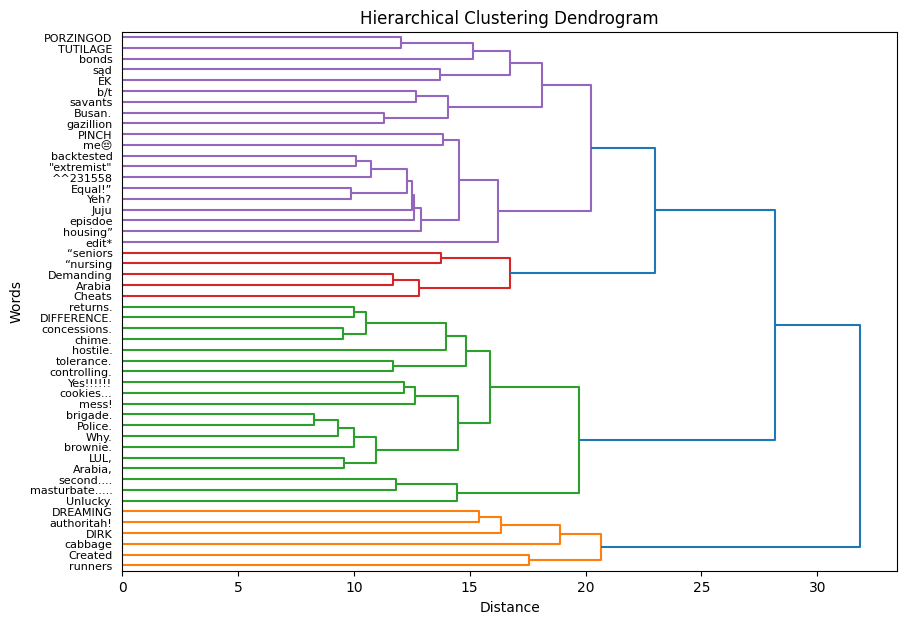

In [27]:
loaded_model.to('cpu')
dendrogram = hierarchical_clustering_on_words(loaded_model, tokenizer, set_of_words, linkage_method='ward')

In [37]:
import torch
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np

def hierarchical_clustering_and_cosine_similarity(model, tokenizer, set_of_words,distance_threshold=None, linkage_method='ward'):
    # Extract the embeddings for the words
    word_embeddings = []
    words = []
    for word in set_of_words:
        input_ids = tokenizer.encode(word, add_special_tokens=False, return_tensors='pt')
        with torch.no_grad():
            outputs = model.bert(input_ids)
        word_embeddings.append(outputs.last_hidden_state.squeeze(0).mean(0).numpy())
        words.append(word)

    # Perform hierarchical clustering
    Z = sch.linkage(word_embeddings, method=linkage_method)

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram = sch.dendrogram(Z, labels=words, orientation='right')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Distance')
    plt.ylabel('Words')
    plt.show()

    # Identify clusters
    if distance_threshold is not None:
        clusters = sch.fcluster(Z, distance_threshold, criterion='distance')
    else:
        clusters = sch.fcluster(Z, t=8, criterion='maxclust')  # Default to a fixed number of clusters, t=8 for example

    # Calculate average cosine similarity within clusters
    cluster_cosine_similarities = []
    word_embeddings = np.array(word_embeddings)
    for cluster_id in np.unique(clusters):
        indices = np.where(clusters == cluster_id)[0]
        cluster_embeddings = word_embeddings[indices]

        if len(cluster_embeddings) > 1:
            cos_similarities = []
            for i in range(len(cluster_embeddings)):
                for j in range(i + 1, len(cluster_embeddings)):
                    cos_sim = np.dot(cluster_embeddings[i], cluster_embeddings[j]) / (np.linalg.norm(cluster_embeddings[i]) * np.linalg.norm(cluster_embeddings[j]))
                    cos_similarities.append(cos_sim)
            
            avg_cos_sim = np.mean(cos_similarities)
            cluster_cosine_similarities.append(avg_cos_sim)

    return cluster_cosine_similarities

# Example usage
# cosine_similarities = hierarchical_clustering_and_cosine_similarity(model, tokenizer, set_of_words)
# print(cosine_similarities)


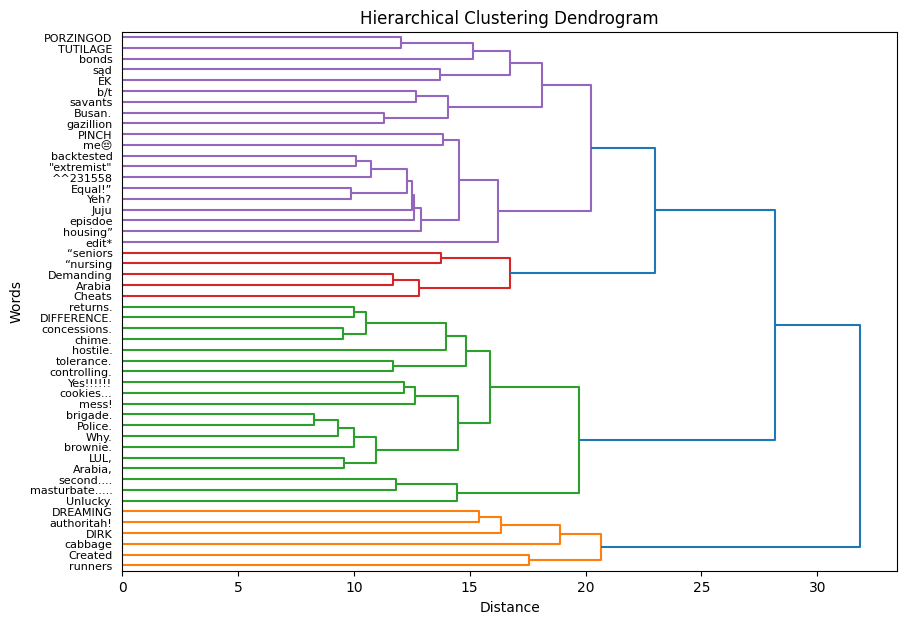

In [43]:
loaded_model.to('cpu')
distance_threshold=10
dendrogram = hierarchical_clustering_and_cosine_similarity(loaded_model, tokenizer, set_of_words, distance_threshold,linkage_method='ward')

In [44]:
avg=sum(dendrogram)/len(dendrogram)

In [45]:
avg

0.714190411567688